In [1]:
import numpy as np
import cv2
import pandas as pd
import PIL
import utm
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import os

In [256]:
subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos

import pickle
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

videos = load_obj('data_wo_segments')

In [3]:
video_name = 'Help'
data = pd.read_fwf('data/head_tracking_data/Subject_6/' + video_name + '.txt', header=None)

data.columns = ['latitude', 'longitude']

cap = cv2.VideoCapture('data/video_files/' + video_name + '.mp4')

In [272]:
test = videos['Help.mp4']['Subject_1']

In [273]:
test['z_2'] = test['z'].shift().apply(str)
test['z_3'] = test['z'].apply(str) + test['z_2'].apply(str)
test['z_4'] = 

In [258]:
# joins together two columns
for video_id in video_list:
    for subj_id in subject_list:
        videos[video_id][subj_id]['z'] = videos[video_id][subj_id]['s_bin_zone'].apply(str) + videos[video_id][subj_id]['s_bin_band'].apply(str) + videos[video_id][subj_id]['e_bin_zone'].apply(str) + videos[video_id][subj_id]['e_bin_band'].apply(str)

In [274]:
test_df = test.iloc[1:]

In [275]:
# videos['Help.mp4']['Subject_1']['z'].value_counts()
test_df

,latitude,longitude,s_zone,s_band,e_zone,e_band,ns_band,ne_band,s_bin_zone,s_bin_band,e_bin_zone,e_bin_band,z,z_2,z_3
1,13.569384,18.680785,24,V,43,H,22,8,2,4,3,2,2432,2432,24322432
2,13.672114,18.687172,24,V,43,H,22,8,2,4,3,2,2432,2432,24322432
3,13.748986,18.684667,24,V,43,H,22,8,2,4,3,2,2432,2432,24322432
4,13.814718,18.690203,24,V,43,H,22,8,2,4,3,2,2432,2432,24322432
5,13.876220,18.702825,24,V,43,H,22,8,2,4,3,2,2432,2432,24322432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,-0.426411,-67.713565,10,U,28,F,21,6,1,4,2,1,1421,1421,14211421
614,-0.725175,-67.861549,10,U,28,F,21,6,1,4,2,1,1421,1421,14211421
615,-0.856629,-67.687099,10,U,28,F,21,6,1,4,2,1,1421,1421,14211421
616,-0.879255,-67.239816,10,U,28,F,21,6,1,4,2,1,1421,1421,14211421


In [287]:
test_df['z_3'].value_counts().loc['34423442']

349

In [192]:
# count unique tiles
video_stat = {}
for video_id in video_list:
    subj_ = {}
    for subj_id in subject_list:
        subj_[subj_id] = videos[video_id][subj_id]['z'].value_counts()
    video_stat[video_id] = subj_

In [193]:
# dynamicity score v2? 
video_score = {}
for video_id in video_list:
    subj_ = {}
    for subj_id in subject_list:
        subj_[subj_id] = np.std(video_stat[video_id][subj_id]) * (len(video_stat[video_id][subj_id])/16)
    video_score[video_id] = subj_

In [194]:
dyn_v2 = pd.DataFrame(pd.DataFrame.from_dict(video_score).mean(axis=1).sort_values(ascending=False).rank())

0    18
dtype: int64

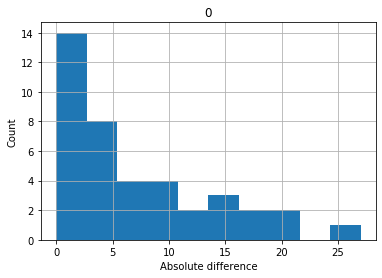

In [228]:
abs(dyn_v2 - dyn_v1_e_n).hist()
plt.ylabel('Count')
plt.xlabel('Absolute difference')
(abs(dyn_v2 - dyn_v1_e_n) < 4).sum()

In [200]:
df = pd.DataFrame.from_dict(video_score)

In [212]:
print(df.iloc[0].var(), 'single user variance between videos')
print(df['A380.mp4'].var(), 'variance of a video')

279.54620838217096 single user variance between videos
77.54956836429993 variance of a video


In [221]:
least_dynamic = df.mean().sort_values().index[0:3]
most_dynamic = df.mean().sort_values().index[-3:]

In [110]:
hard_way = ['Predator.mp4', 'Help.mp4', 'DrivingInAlps.mp4']

In [224]:
import itertools

def combinations(df, full_df):
    ret_ = pd.DataFrame()
    for i in itertools.combinations(df, len(df)-1):
        ret_[i] = abs(full_df[i[0]].rank() - full_df[i[1]].rank())
    return ret_
    
tt = combinations(most_dynamic, df)


In [225]:
tt.mean()

(CMLauncher.mp4, AirShow.mp4)    15.400
(CMLauncher.mp4, RingMan.mp4)    10.625
(AirShow.mp4, RingMan.mp4)       13.600
dtype: float64

In [215]:
# new_df.columns = new_df.columns.str.replace('.mp4', '')
# new_df = df.reindex(df.mean().sort_values(ascending=False).index, axis=1)
# new_df.boxplot(figsize=(26,10), rot=90)
# plt.ylabel('Dynamicity score')

In [3]:
def start_end_point(lat, lon):
    start = [lon - 55, lat + 50]
    end = [lon + 55, lat - 50]
    if start[0] > 180:
        start[0] = start[0] - 360
    elif start[0] < -180:
        start[0] = start[0] + 360
    if start[1] > 80:
        start[1] = start[1] - 160
    elif start[1] < - 80:
        start[1] = start[1] + 160

    if end[0] > 180:
        end[0] = end[0] - 360
    elif end[0] < -180:
        end[0] = end[0] + 360
    if end[1] > 80:
        end[1] = end[1] - 160
    elif end[1] < - 80:
        end[1] = end[1] + 160

    return(start, end)

starting_points = []
ending_points = []

# Determine top left and bottom right UTM coordinates of the viewport
for i in range(len(data)):
    start, end = start_end_point(data.iloc[i]['latitude'], data.iloc[i]['longitude'])
    
    start_utm = utm.from_latlon(start[1], start[0])
    starting_points.append(start_utm[2:])
    
    end_utm = utm.from_latlon(end[1], end[0])
    ending_points.append(end_utm[2:])

starting_zones = pd.DataFrame(starting_points)
ending_zones = pd.DataFrame(ending_points)

In [4]:
# concatenate zones and zone bands to dataframe
coords = pd.concat([data, starting_zones, ending_zones],axis=1)
coords.columns = ['latitude', 'longitude', 's_zone', 's_band', 'e_zone', 'e_band']

In [5]:
# convert band-letters to numbers - issue exists because mercator zones omit the letters "I" and "O"
coords['ns_band'] = [ ord(x) - 64 for x in coords.s_band ]
coords['ne_band'] = [ ord(x) - 64 for x in coords.e_band ]

In [6]:
# Probably here we can work out the size of a tile
# Determine bins (for 4x4 tiling it will be 15 UTM zones and 6 UTM bands)
bins_zone = [i*15 for i in range(0,5)]
labels_zone = [i for i in range(1,5)]

bins_band = [i*6 for i in range(0,5)]
labels_band = [i for i in range(1,5)]

# Binning results
coords['s_bin_zone'] = pd.DataFrame(pd.cut(coords['s_zone'], bins=bins_zone, labels=labels_zone))
coords['s_bin_band'] = pd.DataFrame(pd.cut(coords['ns_band'], bins=bins_band, labels=labels_band))
coords['e_bin_zone'] = pd.DataFrame(pd.cut(coords['e_zone'], bins=bins_zone, labels=labels_zone))
coords['e_bin_band'] = pd.DataFrame(pd.cut(coords['ne_band'], bins=bins_band, labels=labels_band))

In [44]:
G = nx.DiGraph()
for i in range(len(coords)-1):

    prev_top_left_zone = (coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band'])
    prev_bottom_right_zone = (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])
    curr_top_left_zone = (coords.iloc[i+1]['s_bin_zone'], coords.iloc[i+1]['s_bin_band'])
    curr_bottom_right_zone = (coords.iloc[i+1]['e_bin_zone'], coords.iloc[i+1]['e_bin_band'])

    # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]
    G.add_edge((prev_top_left_zone, prev_bottom_right_zone), (curr_top_left_zone, curr_bottom_right_zone))
    

In [245]:
# attempting to get statistics for all videos and all users

subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos

all_videos = {}

for video_id in video_list:
    stats_subj = {}
    for subj_id in subject_list:
        G = nx.DiGraph()
        ti = pd.DataFrame()
        for i in range(len(videos[video_id][subj_id])-1):

            prev_top_left_zone = (videos[video_id][subj_id].iloc[i]['s_bin_zone'], videos[video_id][subj_id].iloc[i]['s_bin_band'])
            prev_bottom_right_zone = (videos[video_id][subj_id].iloc[i]['e_bin_zone'], videos[video_id][subj_id].iloc[i]['e_bin_band'])
            curr_top_left_zone = (videos[video_id][subj_id].iloc[i+1]['s_bin_zone'], videos[video_id][subj_id].iloc[i+1]['s_bin_band'])
            curr_bottom_right_zone = (videos[video_id][subj_id].iloc[i+1]['e_bin_zone'], videos[video_id][subj_id].iloc[i+1]['e_bin_band'])

            # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]

            # G.add_edge((prev_top_left_zone, prev_bottom_right_zone), (curr_top_left_zone, curr_bottom_right_zone), weight=0.3)
            
        stats_subj[subj_id] = G

    all_videos[video_id] = stats_subj


KeyboardInterrupt: 

In [236]:
df['A380.mp4']['Subject_1']

37.79074787563749

In [59]:
# def save_obj(obj, name ):
#     with open('obj/'+ name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# save_obj(all_videos, 'single_user_ngs(all)')
all_videos = load_obj('single_user_ngs(all)')

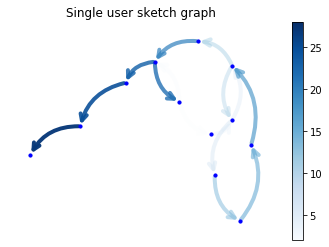

In [146]:
G = all_videos['Help.mp4']['Subject_1']
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [i / M  for i in range(1,M+1)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=10, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=10,
    arrowstyle="->",
    arrowsize=16,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    connectionstyle="arc3,rad=0.3",
    width=4,
)
# set alpha value for each edge
for i in range(M):
    # print(G.edges)
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)
ax = plt.gca()
ax.set_axis_off()
plt.title('Single user sketch graph')
plt.show()


In [184]:
coords = data_wo['A380.mp4']['Subject_1']
# Check whether amount of nodes corresponds with the amount of unique views in a data set
lst = []
for i in range(len(coords)):
    lst.append(((coords.iloc[i]['s_bin_zone'], coords.iloc[i]['s_bin_band']), (coords.iloc[i]['e_bin_zone'], coords.iloc[i]['e_bin_band'])))

df = pd.DataFrame(lst)
df.columns = ['starts', 'ends']

no_uniques = len(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))
no_nodes = G.number_of_nodes()

print('Valid output:', no_uniques == no_nodes)
print('No of nodes:', no_nodes)
print('No of uniques:', no_uniques)
print(df.groupby(['starts','ends']).size().reset_index().rename(columns={0:'count'}))

Valid output: False
No of nodes: 3
No of uniques: 12
    starts    ends  count
0   (1, 4)  (2, 1)     57
1   (1, 4)  (2, 2)     27
2   (1, 4)  (3, 1)     23
3   (1, 4)  (3, 2)     11
4   (2, 4)  (3, 1)    176
5   (2, 4)  (3, 2)    102
6   (3, 4)  (1, 1)      4
7   (3, 4)  (1, 2)      2
8   (3, 4)  (4, 1)     14
9   (3, 4)  (4, 2)      3
10  (4, 4)  (1, 1)      5
11  (4, 4)  (1, 2)     14


In [60]:
# Dynamicity score v1/v1 adjusted
video_ = {}
for video_id in video_list:
    subj_ = {}
    for subj_id in subject_list:
        G = all_videos[video_id][subj_id]
        subj_[subj_id] = G.number_of_edges() / G.number_of_nodes()
        # subj_[subj_id] = G.number_of_nodes() / G.number_of_edges()
    video_[video_id] = subj_
        # print(subj_id, G.number_of_nodes() / G.number_of_edges())

In [61]:
stat = pd.DataFrame.from_dict(video_)

In [109]:
# stat.sort_index().reset_index(drop=True).to_excel('comparison.xlsx')

In [50]:
# inter_step = pd.DataFrame(stat.mean(axis=1).sort_values(ascending=True))
# dyn_v1 = pd.DataFrame(stat.mean(axis=1).sort_values(ascending=False).rank())
# dyn_v1 = pd.DataFrame(inter_step.rank(ascending=False))

In [211]:
dyn_v1_e_n = pd.DataFrame(stat.mean(axis=1).sort_values(ascending=False).rank())

In [16]:
from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [84]:
replaced = stat
cm = replaced.style.apply(background_gradient, cmap='RdYlGn', m=replaced.min().min(), M=replaced.max().max())


In [84]:
# cm.to_excel('color_comparison_outliers_v3.xlsx')

In [85]:
# f, axes = plt.subplots(8,5, figsize=(24,34))
# names = stat.columns.values.tolist()
# count = 0
# for i in range(8):
#     for j in range(5):
#         stat.boxplot([names[count]], ax=axes[i,j])
#         axes[i,j].set_ylim(1,4.5)
#         count+=1

# f.suptitle('Dynamicity score')
# plt.show()

{(1, 2): Text(1.5, 1.5, '0.5'), (1, 3): Text(1.0, 0.5, '9.8')}

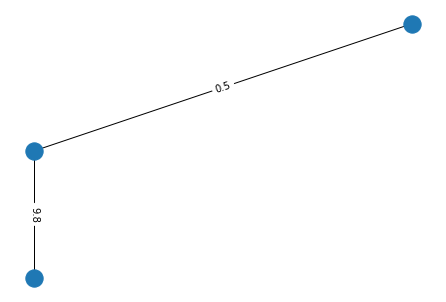

In [147]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.Graph()
i=1
G.add_node(i,pos=(i,i))
G.add_node(2,pos=(2,2))
G.add_node(3,pos=(1,0))
G.add_edge(1,2,weight=0.5)
G.add_edge(1,3,weight=9.8)
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)


# total visits to that specific node / total edges

In [161]:
data_wo = load_obj('data_wo_segments')

In [164]:
data_wo['A380.mp4']['Subject_1']

,latitude,longitude,s_zone,s_band,e_zone,e_band,ns_band,ne_band,s_bin_zone,s_bin_band,e_bin_zone,e_bin_band
0,5.349296,-5.237058,20,U,39,G,21,7,2,4,3,2
1,5.298441,-5.249516,20,U,39,G,21,7,2,4,3,2
2,5.272040,-5.285644,20,U,39,G,21,7,2,4,3,2
3,5.244004,-5.325556,20,U,39,G,21,7,2,4,3,2
4,5.198481,-5.342462,20,U,39,G,21,7,2,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
433,-6.567370,-15.886104,19,T,37,E,20,5,2,4,3,1
434,-6.718526,-16.971960,19,T,37,E,20,5,2,4,3,1
435,-6.910550,-18.376231,18,T,37,E,20,5,2,4,3,1
436,-7.144737,-19.923288,18,T,36,E,20,5,2,4,3,1
